# Descenso de gradiente sin uso de pytorch

Usare un conjunto de datos sintetico, ademas usando sus derivadas que obtuvieron en la tarea 1, lo aplican aqui de forma practica.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D


Supongmaos nuestros puntos estan en 3 dimenciones, aqui generamos los datos, ademas de 2 clases a la que pertenece cada punto.

In [ ]:
# Generar datos (Moons en 3D: 2 características de Moons + una característica extra de ruido)
def generate_3d_moons():
    X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
    X = np.hstack([X, np.random.randn(X.shape[0], 1) * 0.1])  # Agregamos una tercera dimensión de ruido
    scaler = StandardScaler() #Estandarizar los valores d elos puntos
    X = scaler.fit_transform(X)
    y = y.reshape(1, -1)  # Convertir y en fila para trabajar con 2 salidas
    y_extended = np.vstack([y, 1 - y])  # Dos neuronas de salida (una para cada clase)
    return X.T, y_extended  # Transponemos para mantener la forma adecuada

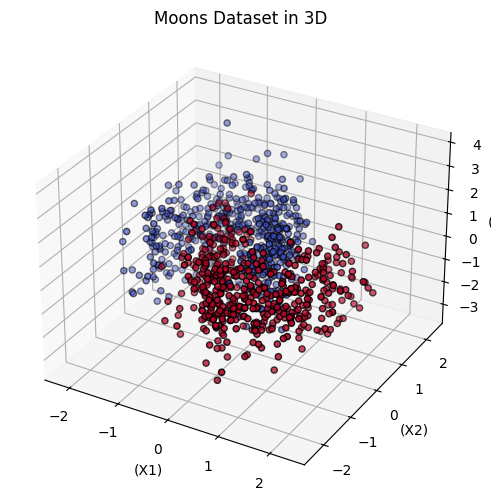

In [ ]:
# Graficamos el dataset en 3D para visualizar las tres dimensiones de los datos
# Generar datos

X, y = generate_3d_moons()
X = X.T  # Convertimos a la forma original para graficar
y = y[0]  # Convertimos la salida a una sola dimensión

# Crear figura 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Graficar puntos en 3D
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap="coolwarm", edgecolors="k")

# Etiquetas de los ejes
ax.set_xlabel("(X1)")
ax.set_ylabel("(X2)")
ax.set_zlabel("(X3)")
ax.set_title("Moons Dataset in 3D")

plt.show()


Definimos las funciones de activacion, junto a las derivadas de las mismas.

In [ ]:
# Definir funciones de activación y sus derivadas
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2


Inicialisacion de pesos de manera aleatoria, esto lo hacemos porque nececitamos valores en los pesos antes de pasarlos a la red, es mejor iniciar en valores diferentes de 0.

In [ ]:
# Inicialización de pesos y bias para 3 entradas y 2 salidas
def initialize_weights():
    np.random.seed(42)
    W1 = np.random.randn(6, 3) * 0.01  # 6 neuronas en la primera capa oculta
    b1 = np.zeros((6, 1))
    W2 = np.random.randn(6, 6) * 0.01  # 6 neuronas en la segunda capa oculta
    b2 = np.zeros((6, 1))
    W3 = np.random.randn(2, 6) * 0.01  # 2 neuronas de salida (sin activación)
    return W1, b1, W2, b2, W3

Propagacion hacia delanet o forward, es basicamente la multiplicacion, es basicamente donde se obtiene la combinacion lineal de los valores.

In [ ]:
# Forward Propagation con 2 neuronas de salida sin activación
def forward_propagation(X, W1, b1, W2, b2, W3):
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)

    z2 = np.dot(W2, a1) + b2
    a2 = tanh(z2)

    z3 = np.dot(W3, a2)  # Sin activación en la salida
    return z1, a1, z2, a2, z3

La funcion de perdida a usar, cuando la hicimos a mano tenamis que se obtenia un promedio pero con $2/m$ ,normalmente en vez de 2 simplemente se toma le promedio normal, para el MSE, recordando que la funcion de perdida debe ser un escalar.

In [ ]:
# Función de pérdida (MSE) para salida sin activación
def compute_mse_loss(y_pred, y):
    return np.mean((y_pred - y) ** 2)

El paso mas relevante, la retropropagacion, es donde hacemos el calculo de los gradientes respecto de los pesos y sesgos, que obtuvimos a mano.

In [ ]:
# Backpropagation
def backward_propagation(X, y, z1, a1, z2, a2, z3, W2, W3, learning_rate):
    m = X.shape[1]

    dL_dz3 = (2 / m) * (z3 - y)  # Gradiente de la pérdida con respecto a la salida
    dL_dW3 = np.dot(dL_dz3, a2.T)  # Gradiente de los pesos de la capa de salida

    dL_dz2 = np.dot(W3.T, dL_dz3) * tanh_derivative(z2)
    dL_dW2 = np.dot(dL_dz2, a1.T)
    dL_db2 = np.sum(dL_dz2, axis=1, keepdims=True)

    dL_dz1 = np.dot(W2.T, dL_dz2) * relu_derivative(z1)
    dL_dW1 = np.dot(dL_dz1, X.T)
    dL_db1 = np.sum(dL_dz1, axis=1, keepdims=True)

    return dL_dW3, dL_dW2, dL_db2, dL_dW1, dL_db1

Funcion para el entrenamiento, donde hace el forward, el caclulo de la perdida y la retropropagacion.

In [ ]:
# Entrenamiento de la red neuronal con salida de 2 neuronas sin activación
def train(X, y, epochs=1000, learning_rate=0.01):
    W1, b1, W2, b2, W3 = initialize_weights()
    losses = []

    for epoch in range(epochs):
        # Forward propagation
        z1, a1, z2, a2, y_hat = forward_propagation(X, W1, b1, W2, b2, W3)
        # Cálculo de la pérdida
        loss = compute_mse_loss(y_hat, y)
        losses.append(loss)

        # Backpropagation
        dL_dW3, dL_dW2, dL_db2, dL_dW1, dL_db1 = backward_propagation(X, y, z1, a1, z2, a2, y_hat, W2, W3, learning_rate)

        # Actualización de pesos
        W3 -= learning_rate * dL_dW3
        W2 -= learning_rate * dL_dW2
        b2 -= learning_rate * dL_db2
        W1 -= learning_rate * dL_dW1
        b1 -= learning_rate * dL_db1

        # Mostrar pérdida cada 100 iteraciones
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: Loss = {loss}")

    return W1, b1, W2, b2, W3, losses

Evaluacion del modelo, donde solo requerimos el forward y los pesos entrenados.

In [ ]:
# Evaluación del modelo
def evaluate(X, y, W1, b1, W2, b2, W3):
    _, _, _, _, y_hat = forward_propagation(X, W1, b1, W2, b2, W3)
    error = np.mean(np.abs(y_hat - y))  # Promedio del error absoluto
    return error

Genearamos los datos, entrenamos y calculamos la perdida.

Epoch 0: Loss = 0.5045001807181496
Epoch 1000: Loss = 0.08362966170909411
Epoch 2000: Loss = 0.0460766315771854
Epoch 3000: Loss = 0.03795712080070463
Epoch 4000: Loss = 0.03417578909080274
Epoch 5000: Loss = 0.02478918308038022
Epoch 6000: Loss = 0.02345603310027186
Epoch 7000: Loss = 0.022548218753717975
Epoch 8000: Loss = 0.021791659688322192
Epoch 9000: Loss = 0.021107849649046745


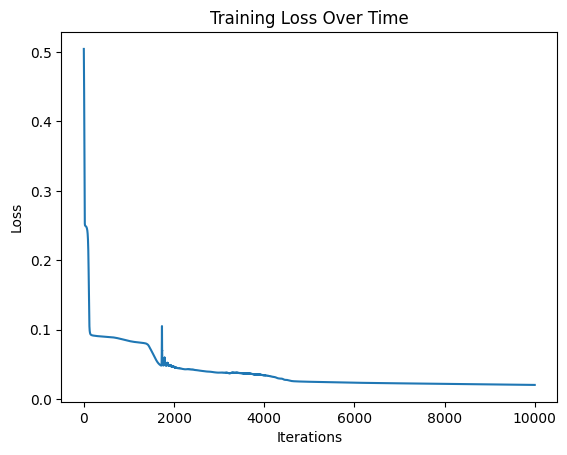

Mean Absolute Error: 0.0704


In [ ]:
X, y = generate_3d_moons()

# Entrenamiento del modelo
W1, b1, W2, b2, W3, losses = train(X, y, epochs=10000, learning_rate=0.1)

# Graficar la pérdida
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()

# Evaluar el modelo
error = evaluate(X, y, W1, b1, W2, b2, W3)
print(f"Mean Absolute Error: {error:.4f}")


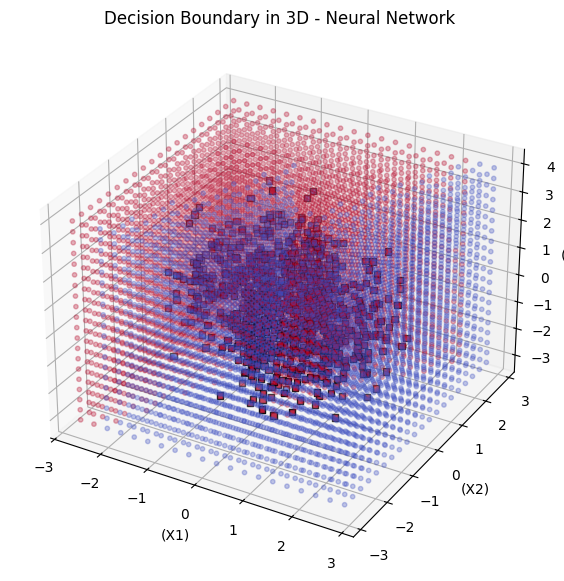

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generar datos
X, y = generate_3d_moons()
X = X.T  # Convertimos a la forma original
y = y[0]  # Convertimos la salida a 1D

# Definir los límites del espacio 3D para la malla
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
z_min, z_max = X[:, 2].min() - 0.5, X[:, 2].max() + 0.5

# Crear la malla de puntos en 3D
x_range = np.linspace(x_min, x_max, 20)
y_range = np.linspace(y_min, y_max, 20)
z_range = np.linspace(z_min, z_max, 20)
xx, yy, zz = np.meshgrid(x_range, y_range, z_range, indexing='ij')

# Aplanar la malla para hacer predicciones
grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]  # (N, 3)

# Propagación hacia adelante para obtener predicciones
_, _, _, _, y_hat = forward_propagation(grid_points.T, W1, b1, W2, b2, W3)

# Obtener las etiquetas predichas
pred_labels = np.argmax(y_hat, axis=0).astype(float)  # (N,)

# Asegurar que los datos sean vectores 1D
x_scatter = grid_points[:, 0].flatten()
y_scatter = grid_points[:, 1].flatten()
z_scatter = grid_points[:, 2].flatten()
c_scatter = pred_labels.flatten()

# Crear la figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Graficar la frontera de decisión (puntos de la malla con color según la red)
ax.scatter(x_scatter, y_scatter, z_scatter,
           c=c_scatter, s=10, alpha=0.3, cmap="coolwarm", marker="o")

# Graficar los datos originales
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap="coolwarm", edgecolors="k", marker="s")

#ax.view_init(elev=10, azim=20)  # Ajusta estos valores según tu preferencia


# Etiquetas de los ejes
ax.set_xlabel("(X1)")
ax.set_ylabel("(X2)")
ax.set_zlabel("(X3)")
ax.set_title("Decision Boundary in 3D - Neural Network")

plt.show()
